### Классификация с помощью дерева решений

1. Разработайте программу, которая выполняет классификацию заданного набора данных с помощью дерева решений. Параметрами программы являются набор данных, критерий выбора атрибута разбиения (Information gain, Gain ratio, Gini index).
2. Проведите эксперименты на наборе Census Income (данные о результатах переписи населения, в т.ч. о годовом доходе -- ниже или выше $50000. В качестве обучающей выборки для построения дерева используйте 100% исходных данных.
3. Выполните визуализацию построенных деревьев решений.
4. Доработайте программу, добавив в список ее параметров долю, которую занимает обучающая выборка от общего размера набора данных, и обеспечив вычисление и выдачу в качестве результатов следующих показателей качества классификации: аккуратность (accuracy), точность (precision), полнота (recall), F-мера.
5. Проведите эксперименты на наборе данных, фиксируя критерий выбора атрибута разбиения и варьируя соотношение мощностей обучающей и тестовой выборок от 60%:40% до 90%:10% с шагом 10%.
6. Выполните визуализацию полученных результатов в виде следующих диаграмм: построенные деревья решений для заданного набора данных; показатели качества классификации в зависимости от соотношения мощностей обучающей и тестовой выборок для заданного набора данных.

In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, ADASYN

import matplotlib.pyplot as plt
import graphviz
import seaborn as sns

In [3]:
train_df = pd.read_csv("train.csv", header = None, na_values = [" ?"])
test_df = pd.read_csv("test.csv", header = None, na_values = [" ?"])
train_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [4]:
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain",
          "capital-loss", "hours-per-week", "native-country", "income"]

train_df.columns = columns
test_df.columns = columns

test_df["income"] = test_df["income"].str.replace(".", "", regex = False) # точка - не означает реагулярное выражение!

df = pd.concat([train_df, test_df])
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
16277,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [5]:
# Заполнение пропущенных значений модой (самым частым значением)
for col in df.columns:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

print(df["income"].value_counts())

income
<=50K    37155
>50K     11687
Name: count, dtype: int64


По результатам видно, что одного класса больше чем другого, а значит необходимо их уравновесить

In [6]:
categorical_columns = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "income"]
df_encoded = df.copy()
for col in categorical_columns:
    df_encoded[col] = LabelEncoder().fit_transform(df[col])
df_encoded

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,6,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,5,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,3,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,3,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,3,338409,9,13,2,9,5,2,0,0,0,40,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,3,215419,9,13,0,9,1,4,0,0,0,36,38,0
16277,64,3,321403,11,9,6,9,2,2,1,0,0,40,38,0
16278,38,3,374983,9,13,2,9,0,4,1,0,0,50,38,0
16279,44,3,83891,9,13,0,0,3,1,1,5455,0,40,38,0


До увеличения количества экземляров
income
0    37155
1    11687
Name: count, dtype: int64
После увеличения количества экзмепляров
income
0    37155
1    37155
Name: count, dtype: int64


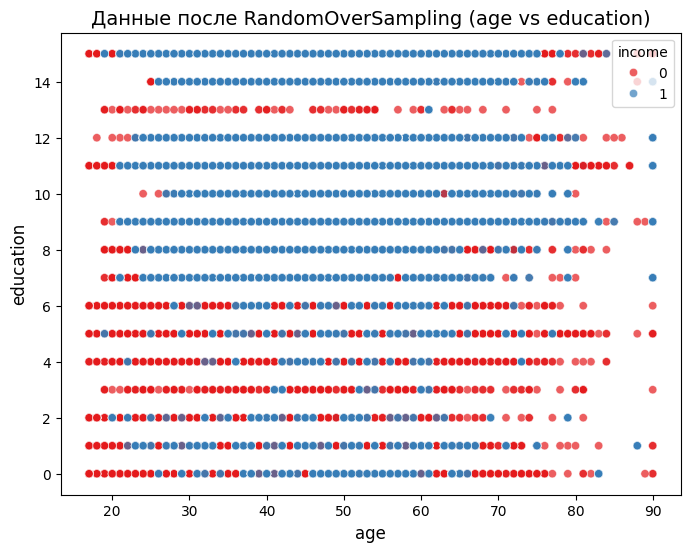

In [7]:
X = df_encoded.drop('income', axis = 1) # Среди столбцов
Y = df_encoded['income']

ros = RandomOverSampler(random_state = 23)
X_resampled, y_resampled = ros.fit_resample(X, Y)
X_resampled['income'] = y_resampled
df_balanced = X_resampled.copy()

print('До увеличения количества экземляров')
print(Y.value_counts())
print('После увеличения количества экзмепляров')
print(y_resampled.value_counts())

plt.figure(figsize = (8, 6))
sns.scatterplot(x = X_resampled['age'],
               y = X_resampled['education'],
               hue = y_resampled,
               palette = 'Set1',
               alpha = 0.7)

plt.title('Данные после RandomOverSampling (age vs education)', fontsize = 14)
plt.xlabel('age', fontsize = 12)
plt.ylabel('education', fontsize = 12)
plt.legend(title = 'income', loc = 'upper right')
plt.show()

После аугментирвания данных видно, что классы были уравнены, то есть количество людей с доходами до 50 тысяч в год и выше 50 тысяч равно.

Критерий: gini
Accuracy:  0.9134
Precision:  0.8687
Recall:  0.9701
F1 score:  0.9166


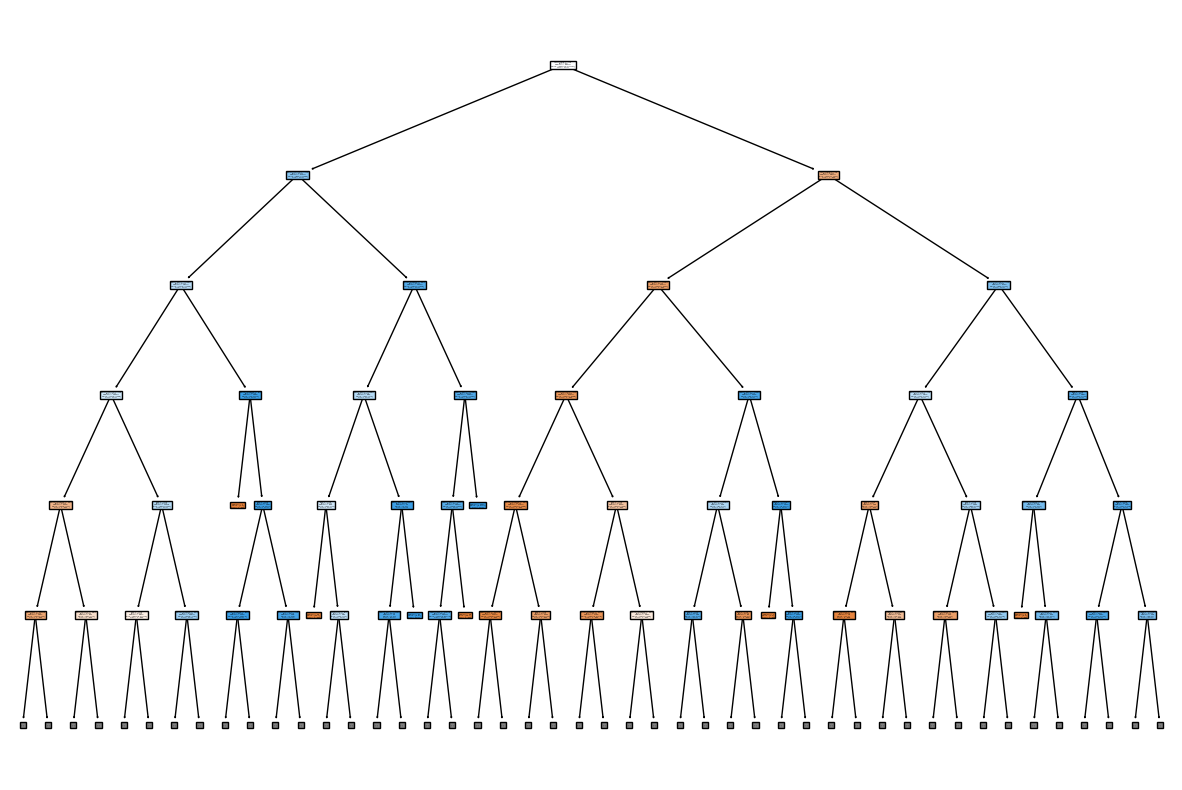

Критерий: entropy
Accuracy:  0.9141
Precision:  0.8678
Recall:  0.9731
F1 score:  0.9174


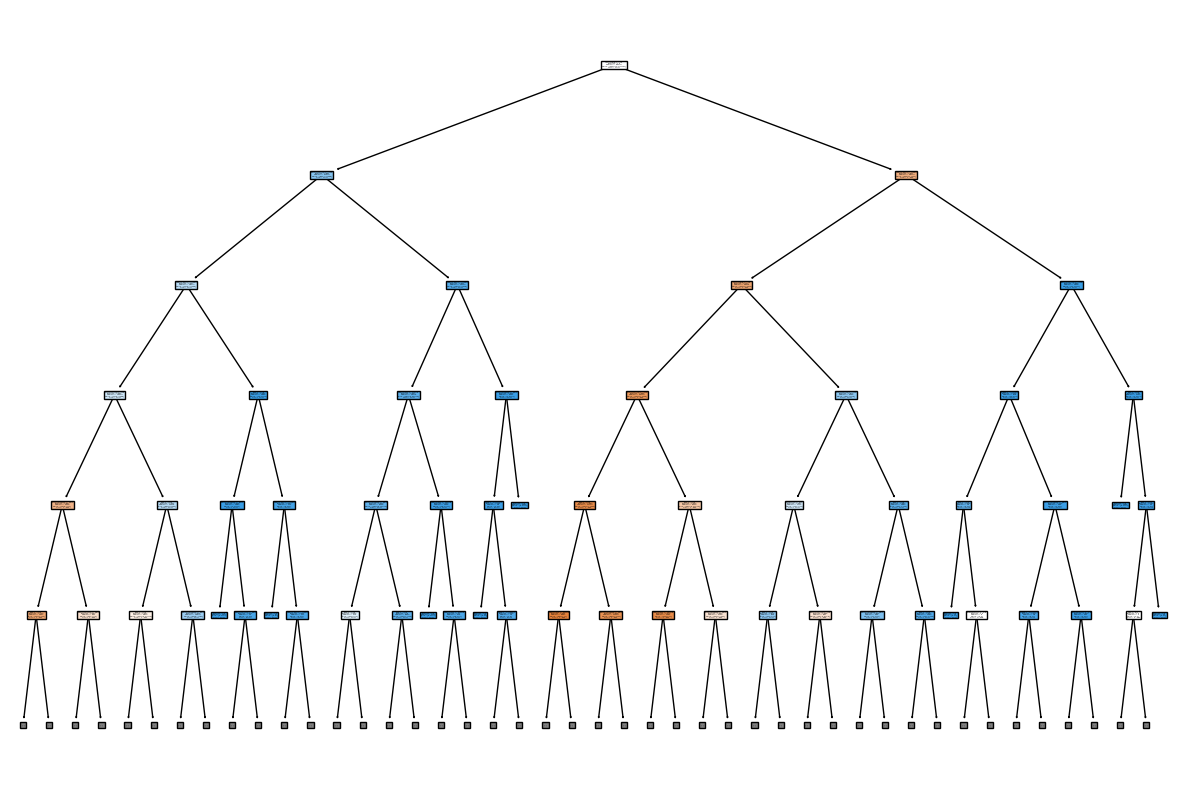

In [8]:
X = df_balanced.drop('income', axis = 1)
Y = df_balanced['income']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 23)

def train_decision_tree(criterion):
    model = DecisionTreeClassifier(criterion = criterion, random_state = 23)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(Y_test, y_pred) # точность (доля правильных предсказаний)
    precision = precision_score(Y_test, y_pred) # точность, доля правильных положительных предсказаний среди всех предсказанных как положительные
    recall = recall_score(Y_test, y_pred) # полнота, доля правильных положительных предсказаний среди всех реальных положительных примеров
    f1 = f1_score(Y_test, y_pred) # показывает, насколько хорошо модель предсказывает положительные случаи, не пропуская их и не ошибаясь слишком часто

    print(f"Критерий: {criterion}")
    print(f"Accuracy: {accuracy: .4f}")
    print(f"Precision: {precision: .4f}")
    print(f"Recall: {recall: .4f}")
    print(f"F1 score: {f1: .4f}")

    # Визуализация дерева
    plt.figure(figsize=(15, 10))
    plot_tree(model, feature_names=X_train.columns, class_names=["<=50K", ">50K"], filled=True, max_depth=5)
    plt.show()

for criterion in ["gini", "entropy"]:
    train_decision_tree(criterion)

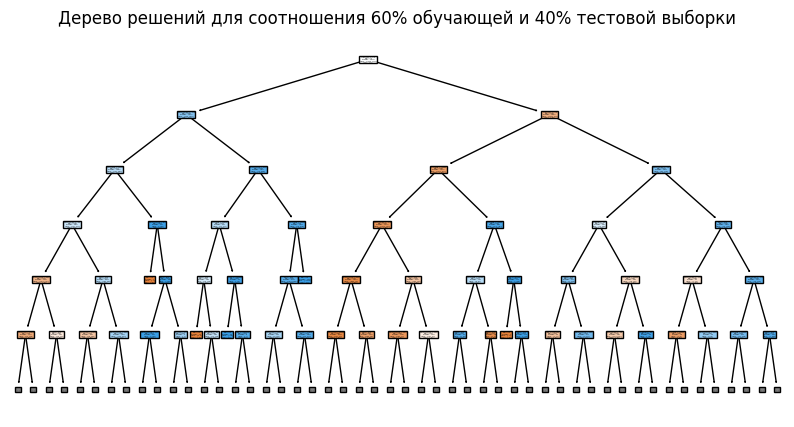

Соотношение 60% обучающей, 40% тестовой выборки:
  Accuracy: 0.8759
  Precision: 0.8418
  Recall: 0.9259
  F1 score: 0.8819
--------------------------------------------------


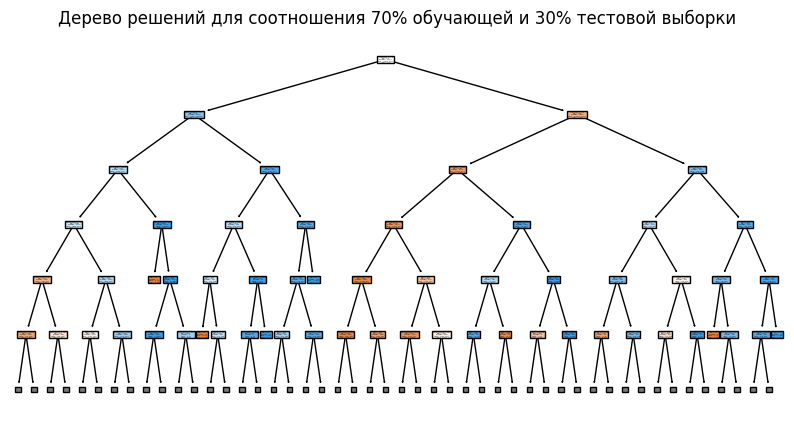

Соотношение 70% обучающей, 30% тестовой выборки:
  Accuracy: 0.8889
  Precision: 0.8508
  Recall: 0.9420
  F1 score: 0.8940
--------------------------------------------------


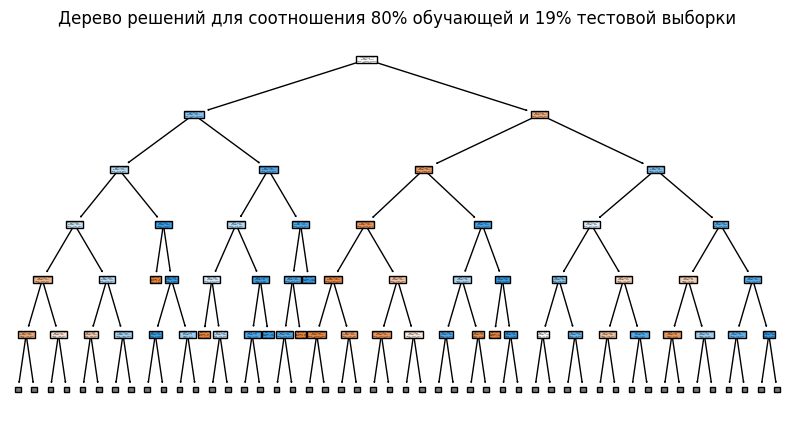

Соотношение 80% обучающей, 19% тестовой выборки:
  Accuracy: 0.8998
  Precision: 0.8599
  Recall: 0.9523
  F1 score: 0.9038
--------------------------------------------------


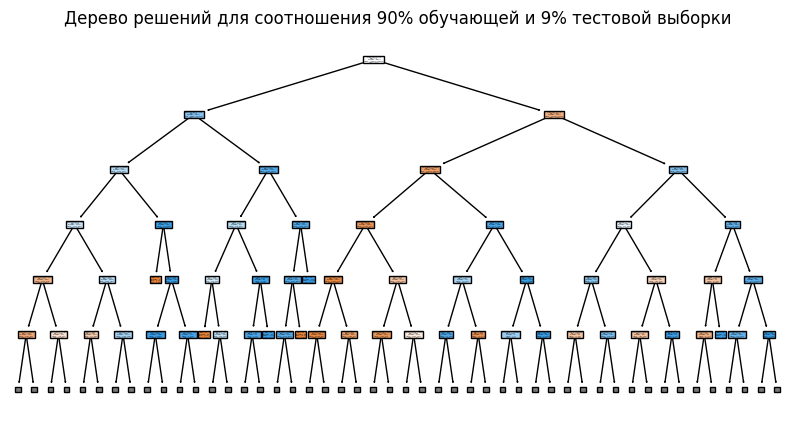

Соотношение 90% обучающей, 9% тестовой выборки:
  Accuracy: 0.9159
  Precision: 0.8794
  Recall: 0.9602
  F1 score: 0.9181
--------------------------------------------------


In [9]:
# Эксперименты
ratios = [0.6, 0.7, 0.8, 0.9]
metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1_score": []
}

for ratio in ratios:
    X_train_part, X_test_part, y_train_part, y_test_part = train_test_split(X_train, Y_train, test_size = 1 - ratio, random_state = 23)

    model = DecisionTreeClassifier(criterion="gini", random_state = 23)
    model.fit(X_train_part, y_train_part)

    plt.figure(figsize=(10, 5))
    plot_tree(model, feature_names=X_train.columns, class_names=["<=50K", ">50K"], filled=True, max_depth=5)
    plt.title(f"Дерево решений для соотношения {int(ratio*100)}% обучающей и {int((1-ratio)*100)}% тестовой выборки")
    plt.show()
    
    y_pred = model.predict(X_test_part)

    accuracy = accuracy_score(y_test_part, y_pred)
    precision = precision_score(y_test_part, y_pred)
    recall = recall_score(y_test_part, y_pred)
    f1 = f1_score(y_test_part, y_pred)

    metrics["accuracy"].append(accuracy)
    metrics["precision"].append(precision)
    metrics["recall"].append(recall)
    metrics["f1_score"].append(f1)

    print(f"Соотношение {int(ratio*100)}% обучающей, {int((1-ratio)*100)}% тестовой выборки:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 score: {f1:.4f}")
    print("-" * 50)


В последних двух вариантах для тестовой выборки взято 9 и 19 процентов данных, так как происходят округления соотношений (например 9.99%), то есть 9.99% ~ к 10%.

После экспериментов видно, что чем больше было данных в обучающей выборке, тем выше значения метрик, так как при увеличении обучающей выборки модель лучше обучается, а значит выдает более точные результаты. Модель видит больше примеров, на которых можно учиться, и точнее распознаёт закономерности в данных. Однако, при их слишком большом количестве есть шанс переобучения модели, а при маленьком, наоборот, недообучения.

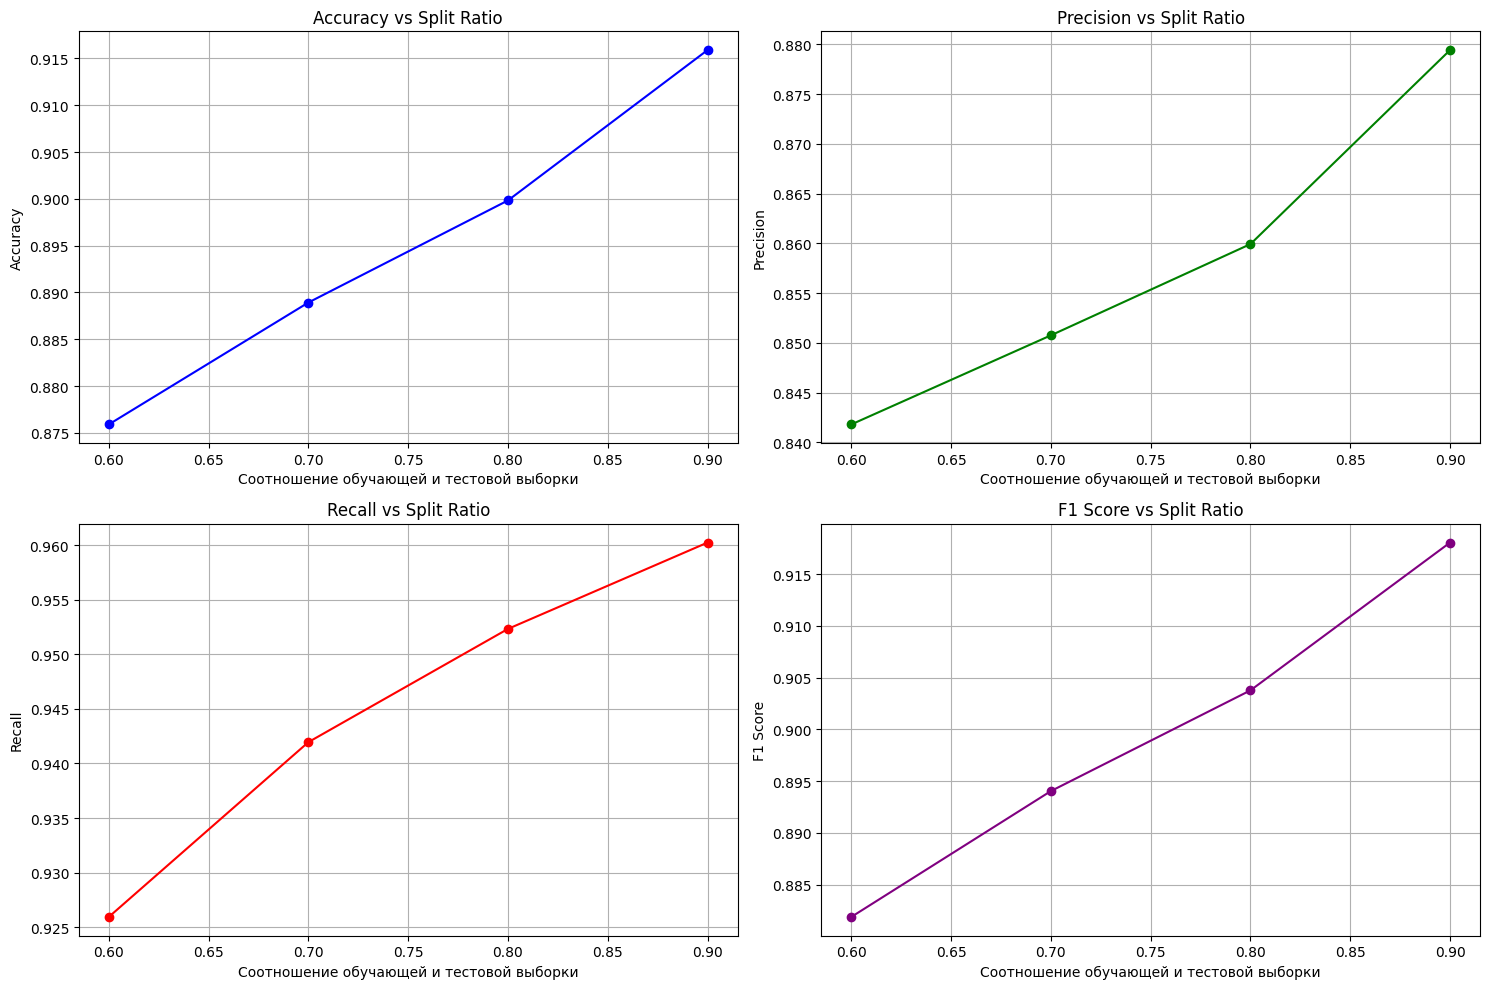

In [10]:
# Визуализация графиков метрик
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
ax[0, 0].plot(ratios, metrics["accuracy"], marker="o", color="b", label="Accuracy")
ax[0, 0].set_title("Accuracy vs Split Ratio")
ax[0, 0].set_xlabel("Соотношение обучающей и тестовой выборки")
ax[0, 0].set_ylabel("Accuracy")
ax[0, 0].grid(True)

# Precision
ax[0, 1].plot(ratios, metrics["precision"], marker="o", color="g", label="Precision")
ax[0, 1].set_title("Precision vs Split Ratio")
ax[0, 1].set_xlabel("Соотношение обучающей и тестовой выборки")
ax[0, 1].set_ylabel("Precision")
ax[0, 1].grid(True)

# Recall
ax[1, 0].plot(ratios, metrics["recall"], marker="o", color="r", label="Recall")
ax[1, 0].set_title("Recall vs Split Ratio")
ax[1, 0].set_xlabel("Соотношение обучающей и тестовой выборки")
ax[1, 0].set_ylabel("Recall")
ax[1, 0].grid(True)

# F1 Score
ax[1, 1].plot(ratios, metrics["f1_score"], marker="o", color="purple", label="F1 Score")
ax[1, 1].set_title("F1 Score vs Split Ratio")
ax[1, 1].set_xlabel("Соотношение обучающей и тестовой выборки")
ax[1, 1].set_ylabel("F1 Score")
ax[1, 1].grid(True)

plt.tight_layout()
plt.show()

Визуализация значений метрик показывает, что чем больше обучающих данных получает модель, тем больше ее точность в дальнейшем, а значит и показатели увеличатся. И наоборот, при небольшом количестве данных для обучающей выборки модель будет иметь худшие показатели, чем могла бы.